In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk_test.test_many_threats.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0    1e1971de-ae1b-42d7-953f-1d1236ae7723
1    69443991-5a70-4458-bd34-db55d5a2fcf5
2    aa6012e8-2001-47e6-981f-9bfc22f29b25
3    29cd59f7-0801-40cf-ace2-6b0f0cf58eee
dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("1688")]

Series([], dtype: object)

In [5]:
target_eid = df_base["eid"].unique()[0]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['1e1971de-ae1b-42d7-953f-1d1236ae7723'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
df["o_ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
df["o_ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed,f_mag,o_ct_v.x,o_ct_v.y
0,0,1e1971de-ae1b-42d7-953f-1d1236ae7723,0.000000,"[-156674.0598399779, 15096.653664246307]",6.710021,"[-566.413704366243, -427.2391616051364]",0.220455,"[3991.7686372857193, 3010.94389625282]",900000.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-397.869550,91.028026,41.399257,709.477121,NaN,7584.214250,660.705685,5000.0,NaN,NaN
1,1,1e1971de-ae1b-42d7-953f-1d1236ae7723,0.016667,"[-156683.50006838402, 15089.533011552889]",6.713695,"[-566.380439627599, -427.214070406001]",0.237122,"[3991.7686372857243, 3010.9438962528134]",900000.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-395.661582,90.875300,41.733437,709.435455,NaN,7572.389631,657.039115,5000.0,NaN,NaN
2,2,1e1971de-ae1b-42d7-953f-1d1236ae7723,0.033333,"[-156692.9397423778, 15082.412777046122]",6.717647,"[-566.347174888955, -427.18897920686555]",0.253789,"[3991.768637285718, 3010.943896252821]",900000.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-393.464663,90.709659,42.092252,709.393788,NaN,7560.565707,653.390891,5000.0,NaN,NaN
3,3,1e1971de-ae1b-42d7-953f-1d1236ae7723,0.050000,"[-156702.3788619593, 15075.292960726007]",6.721877,"[-566.313910150311, -427.1638880077301]",0.270455,"[3991.768637285712, 3010.943896252829]",900000.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-391.278772,90.530806,42.475559,709.352121,NaN,7548.742477,649.760981,5000.0,NaN,NaN
4,4,1e1971de-ae1b-42d7-953f-1d1236ae7723,0.066667,"[-156711.81742712847, 15068.173562592545]",6.726385,"[-566.280645411667, -427.1387968085947]",0.287122,"[3991.7686372856974, 3010.943896252849]",900000.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-389.103888,90.338425,42.883202,709.310455,NaN,7536.919942,646.149350,5000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,662,1e1971de-ae1b-42d7-953f-1d1236ae7723,11.033333,"[-162060.14150932216, 11582.016783530882]",6.037674,"[-282.31121393972626, -333.99425919822727]",0.155588,"[490015.2974190634, -99423.3790177483]",-42812.098772,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-29.610022,97.001323,-24.305212,437.323435,70.511835,1247.011599,35.082496,500000.0,-497.671852,-228.140388
663,663,1e1971de-ae1b-42d7-953f-1d1236ae7723,11.050000,"[-162064.84669622115, 11576.450212544245]",6.040267,"[-278.2277531279007, -334.8227873567085]",0.154795,"[490983.50542574364, -94526.17309427458]",620399.653964,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-29.053779,97.064024,-24.053593,435.335482,67.000215,1239.790230,34.406077,500000.0,-493.670330,-229.301826
664,664,1e1971de-ae1b-42d7-953f-1d1236ae7723,11.066667,"[-162069.48382543997, 11570.869832754966]",6.042847,"[-274.1362239160195, -335.61050546582743]",0.166284,"[491127.96592557704, -93772.7097070637]",-69608.305192,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-28.339789,97.125757,-23.803095,433.341760,63.536211,1232.594399,33.544569,500000.0,-489.664324,-230.447700
665,665,1e1971de-ae1b-42d7-953f-1d1236ae7723,11.083333,"[-162074.05276250522, 11565.276324330536]",6.045619,"[-270.0434908666397, -336.3919447133863]",0.164995,"[491267.6704844612, -93038.03489310629]",-106778.117797,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-27.793329,97.191352,-23.533830,431.373420,60.127726,1225.424618,32.883016,500000.0,-485.653908,-231.578043


# Basic Ship Vitals

## Position and Heading

In [10]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=11.100000000000131, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

In [11]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,667.000000,667.000000
mean,-159422.274995,13206.328751
std,1579.500544,997.640249
min,-162078.553487,11559.669792
25%,-160803.898960,12352.793762
50%,-159381.664377,13116.958058
75%,-158069.532945,14044.482758
max,-156674.059840,15096.653664


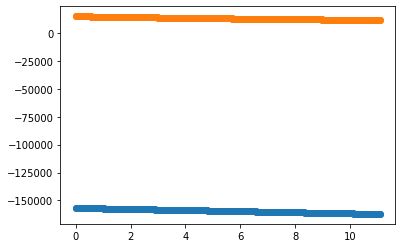

In [12]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

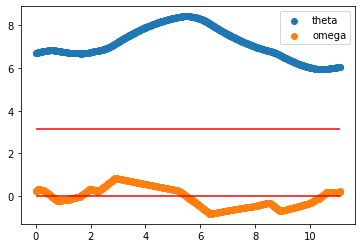

In [13]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()

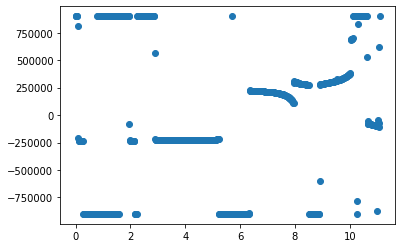

In [14]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

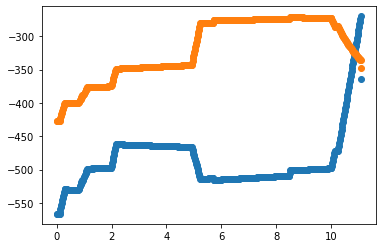

In [15]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

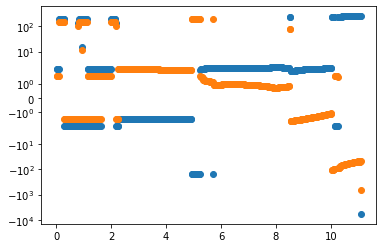

In [16]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

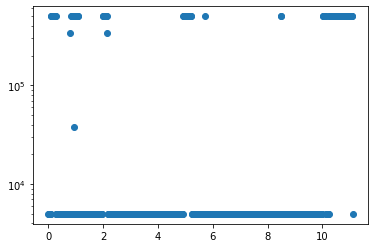

In [17]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")

# Behavior Monitoring

In [18]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=11.100000…

<function __main__.plot_collision_info(hist_length, max_time)>

## Target Location

In [19]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o_t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                o_t_dist            
                            count  min   max          min         max
o.t_loc.x      o.t_loc.y                                             
-162728.945556 10529.524943   667  0.0  11.1  1218.280859  7584.21425

(1218.2808594347198, 1218.2808594347198)

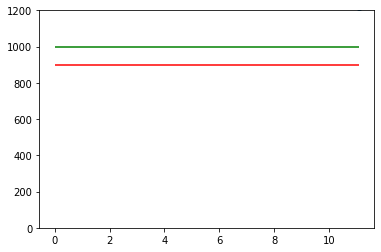

In [20]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
sample = df
plt.scatter(sample["ts"], sample["o_t_dist"])
plt.hlines(1000, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(900, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0,1200)
sample["o_t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o_t_dist"].min()

(0.0, 778.8569233325326)

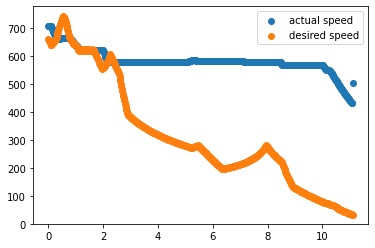

In [21]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)

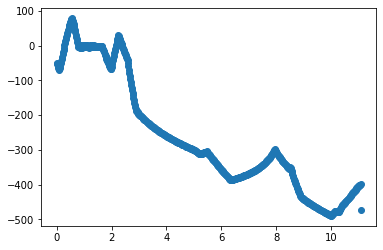

In [22]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

## Collision Avoidance

In [23]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o_ct_dist": ["min","max"]})
else:
    x = "no collision threats"
x

ts                         o_ct_dist  \
                                     count       min        max          min   
o.ct                                                                           
69443991-5a70-4458-bd34-db55d5a2fcf5   148  8.516667  11.083333    60.127726   
aa6012e8-2001-47e6-981f-9bfc22f29b25   216  2.250000  11.100000  1069.990357   

                                                   
                                              max  
o.ct                                               
69443991-5a70-4458-bd34-db55d5a2fcf5   454.923621  
aa6012e8-2001-47e6-981f-9bfc22f29b25  4826.317290

60.12772643967694

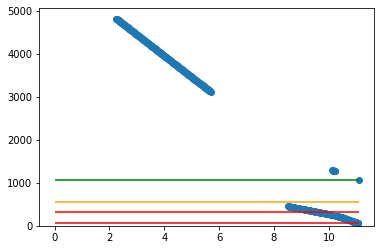

In [24]:
sample = df
plt.scatter(sample["ts"], sample["o_ct_dist"])
plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
plt.hlines(330, sample["ts"].min(), sample["ts"].max(), color="red")
plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0)
df["o_ct_dist"].min()

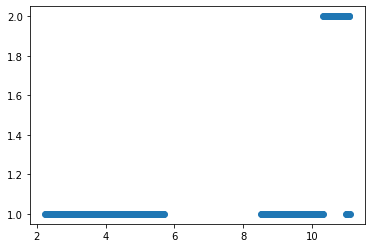

In [25]:
plt.scatter(df["ts"], df["o.ct_ct"])

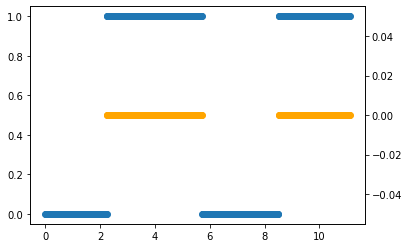

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

# History Visualization

## Position and Velocity

In [27]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True):
    print(max_time)
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o_ct_v.x"], sample["o_ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1000, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 900, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=20, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=11.100000…

<function __main__.plot_collision_chart(hist_length=11.100000000000131, max_time=11.100000000000131, sampling_interval=50, show_tloc=True)>

## Position and Heading

In [28]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=11.100000…

<function __main__.plot_collision_chart(hist_length=11.100000000000131, max_time=11.100000000000131)>

# 